### imports

In [67]:
import numpy as np
import hypertools as hyp
import matplotlib.pyplot as plt
import seaborn as sns
import re
import joblib
import cortex
import tables
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from scipy.spatial.distance import cdist

from stimulus_utils import load_grids_for_stories, load_generic_trfiles
from dsutils import make_word_ds, make_semantic_model
from npp import zscore
from util import make_delayed
from ridge import bootstrap_ridge


from nltk.corpus import stopwords

import logging
logging.basicConfig(level=logging.DEBUG)

% matplotlib inline

DEBUG:matplotlib.backends:backend module://ipykernel.pylab.backend_inline version unknown


In [68]:
sns.set_context('talk')

In [27]:
from SemanticModel import SemanticModel
eng1000 = SemanticModel.load("../data/english1000sm.hf5")

DEBUG:SemanticModel:Loading file: data/english1000sm.hf5
DEBUG:SemanticModel:Done loading file..


### load data

In [2]:
# stories for fitting regression mdoels
Rstories = ['alternateithicatom', 'avatar', 'howtodraw', 'legacy', 'life', 'myfirstdaywiththeyankees', 
                    'naked', 'odetostepfather', 'souls', 'undertheinfluence']

# story for testing regression models/predicting activity
Pstories = ['wheretheressmoke']

allstories = Rstories + Pstories

In [3]:
# Load TextGrids
grids = load_grids_for_stories(allstories)

# Load TRfiles
trfiles = load_generic_trfiles(allstories)

# Make word datasequences
wordseqs = make_word_ds(grids, trfiles) # dictionary of {storyname : word DataSequence}

In [4]:
# load wikipedia articles
wiki_corpus = hyp.load('wiki').data[0]

# fix encoding, remove newlines
wiki_corpus = np.array([doc[0].decode('utf8').replace('\n', ' ') for doc in wiki_corpus])

# remove odd characters
for i, doc in enumerate(wiki_corpus):
    wiki_corpus[i] = re.sub("[^\w\s'-]+", '', doc)

In [5]:
# combine wikipedia pages and stories into full corpus
training_corpus = np.append(wiki_corpus, np.array([' '.join(wordseqs[story].data) for story in allstories]), 0)

In [12]:
# fMRI data
resptf = tables.open_file("../data/fmri-responses.hf5")
zRresp = resptf.root.zRresp.read()
zPresp = resptf.root.zPresp.read()
mask = resptf.root.mask.read()

In [34]:
# regression model params
alphas = np.logspace(1, 3, 10)
nboots = 1
chunklen = 40
nchunks = 20

# param for concatenating stories
trim = 5

# functions

In [35]:
def lanczosinterp2D(data, oldtime, newtime, window=3, cutoff_mult=1.0):
    
    """Interpolates the columns of [data], assuming that the i'th row of data corresponds to
    oldtime(i). A new matrix with the same number of columns and a number of rows given
    by the length of [newtime] is returned.
    
    The time points in [newtime] are assumed to be evenly spaced, and their frequency will
    be used to calculate the low-pass cutoff of the interpolation filter.
    
    [window] lobes of the sinc function will be used. [window] should be an integer.
    """
    
    # Find the cutoff frequency
    cutoff = 1/np.mean(np.diff(newtime)) * cutoff_mult
    print ("Doing lanczos interpolation with cutoff=%0.3f and %d lobes." % (cutoff, window))
    
    # Build up sinc matrix
    lancmat = np.zeros((len(newtime), len(oldtime)))
    for ndi in range(len(newtime)):
        lancmat[ndi,:] = lanczosfun(cutoff, newtime[ndi]-oldtime, window)
    
    # Construct new signal by multiplying the sinc matrix by the data
    newdata = np.dot(lancmat, data)

    return newdata

In [36]:
def lanczosfun(cutoff, t, window=3):
    
    """Compute the lanczos function with some cutoff frequency [B] at some time [t].
    If given a [window], only the lowest-order [window] lobes of the sinc function
    will be non-zero.
    """
    
    t = t * cutoff
    val = window * np.sin(np.pi*t) * np.sin(np.pi*t/window) / (np.pi**2 * t**2)
    val[t==0] = 1.0
    val[np.abs(t)>window] = 0.0
    return val

### grid search function

In [37]:
def search_params(topic_opts, window_opts, training_corpus):
    
    output_dict = dict()
    
    for n_topics in topic_opts:
        for wsize in window_opts:
            
            print(f'topics: {n_topics}\twindow size: {wsize}')
            
            # get windows
            windows = []
            for doc in training_corpus:
                text = doc.split()
                for i in range(0, len(text), wsize):
                    windows.append(' '.join(text[i:i+wsize]))
            
            # fit model
            print('fitting model')
            cv = CountVectorizer(stop_words='english')
            fit_cv = cv.fit_transform(windows)
            LDA_wiki = LatentDirichletAllocation(n_components=n_topics, learning_method='batch', 
                                                 random_state=0).fit(fit_cv)
            
            # transform words
            print('projecting stimulus words')
            ldaseqs = dict()
            for story in allstories:
                vecs = np.empty((len(wordseqs[story].data), n_topics))
                for ix, word in enumerate(wordseqs[story].data):
                    vecs[ix] = LDA_wiki.transform(cv.transform([word]))
                ldaseqs[story] = vecs
                
            # downsample to TR scale
            print('downsampling topic vectors')
            huthseqs = dict()
            for story in allstories:
                huthseqs[story] = make_semantic_model(wordseqs[story], eng1000)
            downsampled_ldaseqs = dict()
            for story in allstories:
                downsampled_ldaseqs[story] = lanczosinterp2D(ldaseqs[story], huthseqs[story].data_times, 
                                                             huthseqs[story].tr_times, window=3)
                
            # concatenate across stories
            LDARstim = np.vstack([zscore(downsampled_ldaseqs[story][5+trim:-trim]) for story in Rstories])
            LDAPstim = np.vstack([zscore(downsampled_ldaseqs[story][5+trim:-trim]) for story in Pstories])
            
            # concatenate delays for FIR model
            delLDARstim = make_delayed(LDARstim, range(1, 5))
            delLDAPstim = make_delayed(LDAPstim, range(1, 5))
            
            # run regression analysis
            print('computing alpha')
            Lwt, Lcorr, Lalphas, Lbscorrs, Lvalinds = bootstrap_ridge(delLDARstim, zRresp, delLDAPstim, zPresp, 
                                                                      alphas, nboots, chunklen, nchunks, 
                                                                      singcutoff=1e-10, single_alpha=True)
            # get weights
            LDApred = np.dot(delLDAPstim, Lwt)
            
            # get voxelwise correlations
            print('computing response correlations')
            LDA_voxcorrs = np.zeros((zPresp.shape[1],))
            for vi in range(zPresp.shape[1]):
                LDA_voxcorrs[vi] = np.corrcoef(zPresp[:,vi], LDApred[:,vi])[0,1]
                
            print(f'median correlation: {str(np.median(LDA_voxcorrs))[:5]}')
            
            output_dict[f't{n_topics}_w{wsize}'] = np.median(LDA_voxcorrs)
            
    return output_dict

In [38]:
# define range to search over
topic_opts = [5, 10, 15, 25, 50, 100, 150, 200]
window_opts = [50, 100, 200, 500]

In [39]:
# run function (takes about 9 hrs to run)
output_dict = search_params(topic_opts, window_opts, training_corpus)

topics: 5	window size: 50
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
computing alpha


INFO:ridge_corr:Selecting held-out test set..
INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 20))
INFO:ridge_corr:Training stimulus has Frobenius norm: 122.521
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.02807, max corr=0.41227, over-under(0.20)=160
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.02868, max corr=0.41101, over-under(0.20)=160
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.02925, max corr=0.40808, over-under(0.20)=168
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.02887, max corr=0.40506, over-under(0.20)=169
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.02723, max corr=0.40431, over-under(0.20)=174
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.02551, max corr=0.40393, over-under(0.20)=176
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02450, max corr=0.40357, over-under(0.20)=172
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.02405, max corr=0.40327, over-under(0.20)=173
INFO:

computing response correlations
median correlation: 0.038
topics: 5	window size: 100
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
computing alpha

INFO:ridge_corr:Selecting held-out test set..
INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 20))
INFO:ridge_corr:Training stimulus has Frobenius norm: 121.583
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.03506, max corr=0.37931, over-under(0.20)=178
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.03564, max corr=0.37941, over-under(0.20)=182
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.03615, max corr=0.37884, over-under(0.20)=192
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.03578, max corr=0.37768, over-under(0.20)=187
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.03429, max corr=0.37736, over-under(0.20)=174
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.03275, max corr=0.37806, over-under(0.20)=161
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.03186, max corr=0.37875, over-under(0.20)=160
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.03148, max corr=0.37907, over-under(0.20)=158
INFO:


computing response correlations
median correlation: 0.039
topics: 5	window size: 200
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.

INFO:ridge_corr:Selecting held-out test set..



Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 20))
INFO:ridge_corr:Training stimulus has Frobenius norm: 121.325
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.03242, max corr=0.39334, over-under(0.20)=148
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.03297, max corr=0.39550, over-under(0.20)=152
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.03322, max corr=0.39739, over-under(0.20)=160
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.03219, max corr=0.39764, over-under(0.20)=166
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.02998, max corr=0.39725, over-under(0.20)=161
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.02807, max corr=0.39716, over-under(0.20)=156
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02705, max corr=0.39714, over-under(0.20)=159
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.02662, max corr=0.39708, over-under(0.20)=160
INFO:ridge_corr:Training: alpha=599.484, mean corr=

computing response correlations
median correlation: 0.040
topics: 5	window size: 500
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 20))
INFO:ridge_corr:Training stimulus has Frobenius norm: 122.480
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.02820, max corr=0.33086, over-under(0.20)=146
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.02902, max corr=0.33338, over-under(0.20)=155
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.03000, max corr=0.33693, over-under(0.20)=169
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.03021, max corr=0.34026, over-under(0.20)=172
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.02917, max corr=0.34226, over-under(0.20)=156
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.02785, max corr=0.34277, over-under(0.20)=143
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02702, max corr=0.34237, over-under(0.20)=136
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.02664, max corr=0.34190, over-under(0.20)=132
INFO:ridge_corr:Training: alpha=599.484, mean corr=

computing response correlations
median correlation: 0.030
topics: 10	window size: 50
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 40))
INFO:ridge_corr:Training stimulus has Frobenius norm: 155.513
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.03150, max corr=0.29111, over-under(0.20)=112
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.03266, max corr=0.29309, over-under(0.20)=123
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.03466, max corr=0.29601, over-under(0.20)=142
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.03675, max corr=0.29839, over-under(0.20)=153
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.03717, max corr=0.29847, over-under(0.20)=140
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.03588, max corr=0.29613, over-under(0.20)=115
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.03465, max corr=0.29281, over-under(0.20)=106
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.03401, max corr=0.29030, over-under(0.20)=99
INFO:ridge_corr:Training: alpha=599.484, mean corr=0

computing response correlations
median correlation: 0.031
topics: 10	window size: 100
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 40))
INFO:ridge_corr:Training stimulus has Frobenius norm: 154.331
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.02610, max corr=0.39792, over-under(0.20)=153
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.02720, max corr=0.40018, over-under(0.20)=170
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.02906, max corr=0.40270, over-under(0.20)=188
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.03085, max corr=0.40372, over-under(0.20)=210
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.03078, max corr=0.40306, over-under(0.20)=206
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.02909, max corr=0.40184, over-under(0.20)=203
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02759, max corr=0.40063, over-under(0.20)=199
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.02681, max corr=0.39973, over-under(0.20)=193
INFO:ridge_corr:Training: alpha=599.484, mean corr=

computing response correlations
median correlation: 0.027
topics: 10	window size: 200
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 40))
INFO:ridge_corr:Training stimulus has Frobenius norm: 153.961
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.03387, max corr=0.38200, over-under(0.20)=169
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.03502, max corr=0.38272, over-under(0.20)=185
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.03707, max corr=0.38355, over-under(0.20)=206
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.03916, max corr=0.38371, over-under(0.20)=232
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.03915, max corr=0.38314, over-under(0.20)=223
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.03716, max corr=0.38251, over-under(0.20)=205
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.03536, max corr=0.38184, over-under(0.20)=190
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.03442, max corr=0.38127, over-under(0.20)=189
INFO:ridge_corr:Training: alpha=599.484, mean corr=

computing response correlations
median correlation: 0.030
topics: 10	window size: 500
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 40))
INFO:ridge_corr:Training stimulus has Frobenius norm: 153.997
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.03138, max corr=0.35630, over-under(0.20)=125
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.03243, max corr=0.35771, over-under(0.20)=139
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.03433, max corr=0.35925, over-under(0.20)=162
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.03651, max corr=0.35884, over-under(0.20)=164
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.03720, max corr=0.35683, over-under(0.20)=172
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.03615, max corr=0.35532, over-under(0.20)=161
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.03500, max corr=0.35364, over-under(0.20)=158
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.03438, max corr=0.35240, over-under(0.20)=154
INFO:ridge_corr:Training: alpha=599.484, mean corr=

computing response correlations
median correlation: 0.027
topics: 15	window size: 50
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 60))
INFO:ridge_corr:Training stimulus has Frobenius norm: 179.938
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01882, max corr=0.35342, over-under(0.20)=109
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.01965, max corr=0.35481, over-under(0.20)=119
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.02117, max corr=0.35662, over-under(0.20)=145
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.02294, max corr=0.35730, over-under(0.20)=178
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.02350, max corr=0.35730, over-under(0.20)=185
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.02248, max corr=0.35989, over-under(0.20)=184
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02134, max corr=0.36200, over-under(0.20)=177
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.02072, max corr=0.36339, over-under(0.20)=171
INFO:ridge_corr:Training: alpha=599.484, mean corr=

computing response correlations
median correlation: 0.026
topics: 15	window size: 100
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 60))
INFO:ridge_corr:Training stimulus has Frobenius norm: 176.470
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.02110, max corr=0.35902, over-under(0.20)=115
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.02185, max corr=0.36076, over-under(0.20)=126
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.02344, max corr=0.36276, over-under(0.20)=145
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.02598, max corr=0.36238, over-under(0.20)=167
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.02816, max corr=0.35849, over-under(0.20)=201
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.02866, max corr=0.35977, over-under(0.20)=208
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02833, max corr=0.36435, over-under(0.20)=213
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.02805, max corr=0.36646, over-under(0.20)=215
INFO:ridge_corr:Training: alpha=599.484, mean corr=

computing response correlations
median correlation: 0.020
topics: 15	window size: 200
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 60))
INFO:ridge_corr:Training stimulus has Frobenius norm: 175.920
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.02798, max corr=0.37387, over-under(0.20)=100
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.02884, max corr=0.37696, over-under(0.20)=116
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.03042, max corr=0.38193, over-under(0.20)=134
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.03212, max corr=0.38612, over-under(0.20)=154
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.03203, max corr=0.38660, over-under(0.20)=146
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.02977, max corr=0.38491, over-under(0.20)=138
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02757, max corr=0.38319, over-under(0.20)=129
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.02638, max corr=0.38202, over-under(0.20)=125
INFO:ridge_corr:Training: alpha=599.484, mean corr=

computing response correlations
median correlation: 0.021
topics: 15	window size: 500
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 60))
INFO:ridge_corr:Training stimulus has Frobenius norm: 177.377
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.02949, max corr=0.33644, over-under(0.20)=107
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.03026, max corr=0.33867, over-under(0.20)=118
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.03158, max corr=0.34130, over-under(0.20)=137
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.03276, max corr=0.34313, over-under(0.20)=142
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.03201, max corr=0.34196, over-under(0.20)=128
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.02938, max corr=0.33926, over-under(0.20)=113
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02713, max corr=0.33705, over-under(0.20)=108
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.02598, max corr=0.33564, over-under(0.20)=107
INFO:ridge_corr:Training: alpha=599.484, mean corr=

computing response correlations
median correlation: 0.017
topics: 25	window size: 50
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 100))
INFO:ridge_corr:Training stimulus has Frobenius norm: 200.978
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.02307, max corr=0.34135, over-under(0.20)=57
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.02364, max corr=0.34426, over-under(0.20)=69
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.02485, max corr=0.34936, over-under(0.20)=86
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.02673, max corr=0.35429, over-under(0.20)=108
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.02820, max corr=0.35494, over-under(0.20)=128
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.02781, max corr=0.35208, over-under(0.20)=124
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02655, max corr=0.34871, over-under(0.20)=121
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.02568, max corr=0.34621, over-under(0.20)=119
INFO:ridge_corr:Training: alpha=599.484, mean corr=0.

computing response correlations
median correlation: 0.032
topics: 25	window size: 100
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 100))
INFO:ridge_corr:Training stimulus has Frobenius norm: 202.423
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.02677, max corr=0.37379, over-under(0.20)=100
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.02748, max corr=0.37697, over-under(0.20)=105
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.02887, max corr=0.38199, over-under(0.20)=127
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.03072, max corr=0.38574, over-under(0.20)=143
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.03146, max corr=0.38516, over-under(0.20)=139
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.02984, max corr=0.38297, over-under(0.20)=118
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02754, max corr=0.38166, over-under(0.20)=106
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.02611, max corr=0.38101, over-under(0.20)=105
INFO:ridge_corr:Training: alpha=599.484, mean corr

computing response correlations
median correlation: 0.022
topics: 25	window size: 200
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 100))
INFO:ridge_corr:Training stimulus has Frobenius norm: 207.282
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.02947, max corr=0.35666, over-under(0.20)=154
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.03054, max corr=0.36321, over-under(0.20)=166
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.03272, max corr=0.37424, over-under(0.20)=223
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.03616, max corr=0.38455, over-under(0.20)=285
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.03950, max corr=0.38738, over-under(0.20)=336
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.04036, max corr=0.38539, over-under(0.20)=301
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.03937, max corr=0.38307, over-under(0.20)=264
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.03846, max corr=0.38153, over-under(0.20)=252
INFO:ridge_corr:Training: alpha=599.484, mean corr

computing response correlations
median correlation: 0.017
topics: 25	window size: 500
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 100))
INFO:ridge_corr:Training stimulus has Frobenius norm: 203.244
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01835, max corr=0.36817, over-under(0.20)=60
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.01937, max corr=0.37206, over-under(0.20)=65
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.02155, max corr=0.37817, over-under(0.20)=83
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.02508, max corr=0.38256, over-under(0.20)=113
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.02864, max corr=0.38096, over-under(0.20)=137
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.03011, max corr=0.37696, over-under(0.20)=148
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02993, max corr=0.37440, over-under(0.20)=141
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.02955, max corr=0.37313, over-under(0.20)=134
INFO:ridge_corr:Training: alpha=599.484, mean corr=0.

computing response correlations
median correlation: 0.023
topics: 50	window size: 50
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 200))
INFO:ridge_corr:Training stimulus has Frobenius norm: 249.084
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00817, max corr=0.32044, over-under(0.20)=38
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.00863, max corr=0.33086, over-under(0.20)=40
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.00976, max corr=0.35241, over-under(0.20)=59
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01221, max corr=0.38355, over-under(0.20)=94
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.01607, max corr=0.40910, over-under(0.20)=141
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.01961, max corr=0.42106, over-under(0.20)=161
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02119, max corr=0.42591, over-under(0.20)=171
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.02156, max corr=0.42804, over-under(0.20)=171
INFO:ridge_corr:Training: alpha=599.484, mean corr=0.0

computing response correlations
median correlation: 0.012
topics: 50	window size: 100
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..
INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 200))
INFO:ridge_corr:Training stimulus has Frobenius norm: 247.155
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.02370, max corr=0.34015, over-under(0.20)=52
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.02435, max corr=0.34506, over-under(0.20)=56
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.02570, max corr=0.35405, over-under(0.20)=73
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.02784, max corr=0.36367, over-under(0.20)=105
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.02979, max corr=0.36634, over-under(0.20)=128
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.02959, max corr=0.36256, over-under(0.20)=134
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02763, max corr=0.35762, over-under(0.20)=121
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.02600, max corr=0.35373, over-under(0.20)=113
INFO:ri

computing alpha
computing response correlations
median correlation: 0.022
topics: 50	window size: 200
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 200))
INFO:ridge_corr:Training stimulus has Frobenius norm: 250.820
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01653, max corr=0.29942, over-under(0.20)=20
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.01699, max corr=0.30598, over-under(0.20)=25
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.01813, max corr=0.31966, over-under(0.20)=37
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.02063, max corr=0.33986, over-under(0.20)=53
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.02461, max corr=0.35676, over-under(0.20)=100
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.02795, max corr=0.36419, over-under(0.20)=121
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02893, max corr=0.36626, over-under(0.20)=146
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.02884, max corr=0.36653, over-under(0.20)=149
INFO:ridge_corr:Training: alpha=599.484, mean corr=0.0

computing response correlations
median correlation: 0.018
topics: 50	window size: 500
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 200))
INFO:ridge_corr:Training stimulus has Frobenius norm: 246.451
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.02395, max corr=0.36571, over-under(0.20)=52
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.02498, max corr=0.37313, over-under(0.20)=60
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.02724, max corr=0.38654, over-under(0.20)=88
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.03115, max corr=0.40049, over-under(0.20)=136
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.03567, max corr=0.40335, over-under(0.20)=232
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.03762, max corr=0.39678, over-under(0.20)=267
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.03629, max corr=0.39021, over-under(0.20)=248
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.03455, max corr=0.38654, over-under(0.20)=233
INFO:ridge_corr:Training: alpha=599.484, mean corr=0.

computing response correlations
median correlation: 0.017
topics: 100	window size: 50
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 400))
INFO:ridge_corr:Training stimulus has Frobenius norm: 301.262
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01147, max corr=0.25910, over-under(0.20)=6
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.01194, max corr=0.27100, over-under(0.20)=10
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.01307, max corr=0.29494, over-under(0.20)=17
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01545, max corr=0.32884, over-under(0.20)=41
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.01942, max corr=0.35402, over-under(0.20)=77
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.02359, max corr=0.35930, over-under(0.20)=105
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02553, max corr=0.35688, over-under(0.20)=105
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.02571, max corr=0.35468, over-under(0.20)=104
INFO:ridge_corr:Training: alpha=599.484, mean corr=0.025

computing response correlations
median correlation: 0.014
topics: 100	window size: 100
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 400))
INFO:ridge_corr:Training stimulus has Frobenius norm: 311.660
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01219, max corr=0.29133, over-under(0.20)=10
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.01295, max corr=0.29903, over-under(0.20)=14
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.01459, max corr=0.31274, over-under(0.20)=23
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01763, max corr=0.32793, over-under(0.20)=43
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.02254, max corr=0.33418, over-under(0.20)=74
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.02824, max corr=0.33083, over-under(0.20)=98
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.03154, max corr=0.32574, over-under(0.20)=117
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.03232, max corr=0.32453, over-under(0.20)=108
INFO:ridge_corr:Training: alpha=599.484, mean corr=0.032

computing response correlations
median correlation: 0.015
topics: 100	window size: 200
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 400))
INFO:ridge_corr:Training stimulus has Frobenius norm: 313.157
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01341, max corr=0.31199, over-under(0.20)=28
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.01430, max corr=0.32106, over-under(0.20)=34
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.01625, max corr=0.33747, over-under(0.20)=51
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01975, max corr=0.35629, over-under(0.20)=85
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.02483, max corr=0.37058, over-under(0.20)=144
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.02996, max corr=0.38786, over-under(0.20)=175
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.03235, max corr=0.39248, over-under(0.20)=174
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.03251, max corr=0.39395, over-under(0.20)=170
INFO:ridge_corr:Training: alpha=599.484, mean corr=0.0

computing response correlations
median correlation: 0.021
topics: 100	window size: 500
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 400))
INFO:ridge_corr:Training stimulus has Frobenius norm: 318.332
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01628, max corr=0.27972, over-under(0.20)=8
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.01714, max corr=0.28915, over-under(0.20)=13
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.01889, max corr=0.30700, over-under(0.20)=22
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.02170, max corr=0.33055, over-under(0.20)=43
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.02527, max corr=0.36173, over-under(0.20)=75
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.02811, max corr=0.37392, over-under(0.20)=93
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02847, max corr=0.37631, over-under(0.20)=90
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.02763, max corr=0.37621, over-under(0.20)=88
INFO:ridge_corr:Training: alpha=599.484, mean corr=0.02701,

computing response correlations
median correlation: 0.023
topics: 150	window size: 50
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 600))
INFO:ridge_corr:Training stimulus has Frobenius norm: 363.185
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01642, max corr=0.23287, over-under(0.20)=2
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.01758, max corr=0.24336, over-under(0.20)=4
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.01992, max corr=0.26392, over-under(0.20)=10
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.02371, max corr=0.29283, over-under(0.20)=22
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.02858, max corr=0.31496, over-under(0.20)=45
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.03266, max corr=0.31880, over-under(0.20)=65
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.03311, max corr=0.31428, over-under(0.20)=62
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.03130, max corr=0.30975, over-under(0.20)=54
INFO:ridge_corr:Training: alpha=599.484, mean corr=0.02986, 

computing response correlations
median correlation: 0.018
topics: 150	window size: 100
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 600))
INFO:ridge_corr:Training stimulus has Frobenius norm: 370.535
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01004, max corr=0.24259, over-under(0.20)=3
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.01109, max corr=0.25082, over-under(0.20)=8
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.01332, max corr=0.26982, over-under(0.20)=22
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01722, max corr=0.29671, over-under(0.20)=48
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.02263, max corr=0.31020, over-under(0.20)=80
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.02805, max corr=0.30568, over-under(0.20)=98
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.03062, max corr=0.29755, over-under(0.20)=107
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.03051, max corr=0.29264, over-under(0.20)=105
INFO:ridge_corr:Training: alpha=599.484, mean corr=0.02994

computing response correlations
median correlation: 0.019
topics: 150	window size: 200
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 600))
INFO:ridge_corr:Training stimulus has Frobenius norm: 385.540
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00980, max corr=0.24190, over-under(0.20)=5
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.01002, max corr=0.25069, over-under(0.20)=9
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.01066, max corr=0.26833, over-under(0.20)=15
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01247, max corr=0.29339, over-under(0.20)=29
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.01608, max corr=0.31156, over-under(0.20)=53
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.02050, max corr=0.31934, over-under(0.20)=92
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02314, max corr=0.32381, over-under(0.20)=100
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.02357, max corr=0.32195, over-under(0.20)=98
INFO:ridge_corr:Training: alpha=599.484, mean corr=0.02335,

computing response correlations
median correlation: 0.016
topics: 150	window size: 500
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 600))
INFO:ridge_corr:Training stimulus has Frobenius norm: 379.261
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01392, max corr=0.32987, over-under(0.20)=26
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.01544, max corr=0.34367, over-under(0.20)=34
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.01834, max corr=0.36624, over-under(0.20)=50
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.02276, max corr=0.38885, over-under(0.20)=89
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.02820, max corr=0.40134, over-under(0.20)=173
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.03266, max corr=0.41682, over-under(0.20)=226
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.03333, max corr=0.41963, over-under(0.20)=216
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.03179, max corr=0.41997, over-under(0.20)=203
INFO:ridge_corr:Training: alpha=599.484, mean corr=0.0

computing response correlations
median correlation: 0.022
topics: 200	window size: 50
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 800))
INFO:ridge_corr:Training stimulus has Frobenius norm: 414.297
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.00751, max corr=0.18832, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.00817, max corr=0.19924, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.00964, max corr=0.21796, over-under(0.20)=4
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.01262, max corr=0.26913, over-under(0.20)=13
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.01766, max corr=0.31666, over-under(0.20)=34
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.02407, max corr=0.33949, over-under(0.20)=88
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02880, max corr=0.34407, over-under(0.20)=116
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.03028, max corr=0.34292, over-under(0.20)=129
INFO:ridge_corr:Training: alpha=599.484, mean corr=0.03040,

computing response correlations
median correlation: 0.014
topics: 200	window size: 100
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 800))
INFO:ridge_corr:Training stimulus has Frobenius norm: 444.077
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01760, max corr=0.31920, over-under(0.20)=8
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.01877, max corr=0.34005, over-under(0.20)=14
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.02086, max corr=0.37544, over-under(0.20)=36
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.02379, max corr=0.41677, over-under(0.20)=83
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.02699, max corr=0.44046, over-under(0.20)=135
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.02918, max corr=0.43882, over-under(0.20)=170
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02877, max corr=0.43096, over-under(0.20)=165
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.02692, max corr=0.42774, over-under(0.20)=153
INFO:ridge_corr:Training: alpha=599.484, mean corr=0.02

computing response correlations
median correlation: 0.036
topics: 200	window size: 200
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 800))
INFO:ridge_corr:Training stimulus has Frobenius norm: 449.487
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01608, max corr=0.19674, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.01738, max corr=0.19119, over-under(0.20)=0
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.01949, max corr=0.20503, over-under(0.20)=1
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.02220, max corr=0.22239, over-under(0.20)=9
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.02512, max corr=0.24493, over-under(0.20)=26
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.02748, max corr=0.26430, over-under(0.20)=44
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.02743, max corr=0.26970, over-under(0.20)=50
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.02553, max corr=0.26978, over-under(0.20)=45
INFO:ridge_corr:Training: alpha=599.484, mean corr=0.02405, ma

computing response correlations
median correlation: 0.021
topics: 200	window size: 500
fitting model
projecting stimulus words
downsampling topic vectors
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.
Doing lanczos interpolation with cutoff=0.499 and 3 lobes.


INFO:ridge_corr:Selecting held-out test set..


computing alpha


INFO:ridge_corr:Doing SVD...
INFO:ridge_corr:Dropped 0 tiny singular values.. (U is now (2937, 800))
INFO:ridge_corr:Training stimulus has Frobenius norm: 456.746
INFO:ridge_corr:Training: alpha=10.000, mean corr=0.01756, max corr=0.23382, over-under(0.20)=8
INFO:ridge_corr:Training: alpha=16.681, mean corr=0.01885, max corr=0.24819, over-under(0.20)=16
INFO:ridge_corr:Training: alpha=27.826, mean corr=0.02058, max corr=0.28112, over-under(0.20)=22
INFO:ridge_corr:Training: alpha=46.416, mean corr=0.02287, max corr=0.32622, over-under(0.20)=50
INFO:ridge_corr:Training: alpha=77.426, mean corr=0.02639, max corr=0.35093, over-under(0.20)=106
INFO:ridge_corr:Training: alpha=129.155, mean corr=0.03070, max corr=0.35327, over-under(0.20)=151
INFO:ridge_corr:Training: alpha=215.443, mean corr=0.03270, max corr=0.35034, over-under(0.20)=167
INFO:ridge_corr:Training: alpha=359.381, mean corr=0.03206, max corr=0.34801, over-under(0.20)=152
INFO:ridge_corr:Training: alpha=599.484, mean corr=0.03

computing response correlations
median correlation: 0.021


In [96]:
# # save out results
# with open('param_search.p', 'wb') as f:
#     pickle.dump(output_dict, f)

In [ ]:
# load in results
with open('param_search.p', 'rb') as f:
    output_dict = pickle.load(f)

In [102]:
output_dict

{'t100_w100': 0.01587027631967619,
 't100_w200': 0.021689974849120115,
 't100_w50': 0.014794131730306768,
 't100_w500': 0.02355096383284238,
 't10_w100': 0.02785412031084032,
 't10_w200': 0.03070530952003156,
 't10_w50': 0.031160058535650972,
 't10_w500': 0.027444627245801823,
 't150_w100': 0.019723834832609734,
 't150_w200': 0.016455425673771132,
 't150_w50': 0.018286002702085438,
 't150_w500': 0.02299699722197819,
 't15_w100': 0.020166365938751877,
 't15_w200': 0.02138423177067568,
 't15_w50': 0.026153249081666385,
 't15_w500': 0.01720503205834003,
 't200_w100': 0.03664252827562457,
 't200_w200': 0.021646719065568934,
 't200_w50': 0.014387209188794364,
 't200_w500': 0.02197151787594756,
 't25_w100': 0.02243145465726691,
 't25_w200': 0.017014336969915923,
 't25_w50': 0.03286811083264847,
 't25_w500': 0.02382122246911248,
 't50_w100': 0.022993364858437816,
 't50_w200': 0.01837938814902054,
 't50_w50': 0.012442694499907524,
 't50_w500': 0.01741217886267219,
 't5_w100': 0.039285112684016

In [57]:
# format results for plotting
t5 = np.mean([v for k, v in output_dict.items() if 't5' in k])
t10 = np.mean([v for k, v in output_dict.items() if 't10' in k])
t15 = np.mean([v for k, v in output_dict.items() if 't15' in k])
t25 = np.mean([v for k, v in output_dict.items() if 't25' in k])
t50 = np.mean([v for k, v in output_dict.items() if 't50' in k])
t100 = np.mean([v for k, v in output_dict.items() if 't100' in k])
t150 = np.mean([v for k, v in output_dict.items() if 't150' in k])
t200 = np.mean([v for k, v in output_dict.items() if 't200' in k])
w50 = np.mean([v for k, v in output_dict.items() if 'w50' in k])
w100 = np.mean([v for k, v in output_dict.items() if 'w100' in k])
w200 = np.mean([v for k, v in output_dict.items() if 'w200' in k])
w500 = np.mean([v for k, v in output_dict.items() if 'w500' in k])

In [70]:
# median correlation of Huth model predictions (copied from other notebook)
Huth_pred_acc = 0.06684583347295449

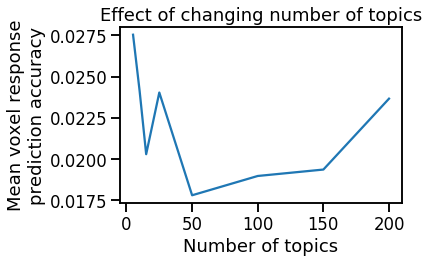

In [103]:
plt.plot([5, 10, 15, 25, 50, 100, 150, 200], [t5, t10, t15, t25, t50, t100, t150, t200])
# un-comment this line to compare to Huth model accuracy
# plt.axhline(Huth_pred_acc, color='r')
plt.xlabel('Number of topics')
plt.ylabel('Mean voxel response\nprediction accuracy')
plt.title('Effect of changing number of topics')
plt.tight_layout()

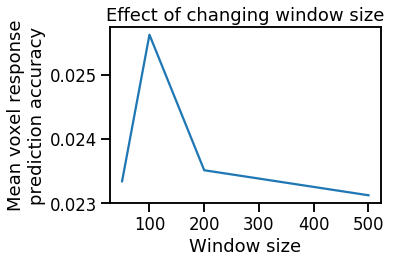

In [101]:
plt.plot([50, 100, 200, 500], [w50, w100, w200, w500])
# un-comment this line to compare to Huth model accuracy
# plt.axhline(Huth_pred_acc, color='r')
plt.xlabel('Window size')
plt.ylabel('Mean voxel response\nprediction accuracy')
plt.title('Effect of changing window size')
plt.tight_layout()

In [106]:
params = list(output_dict.keys())
corrs = list(output_dict.values())

# best combination of parameters
best_param = params[np.argmax(corrs)]
print(f'best combination of n_topics and window size:\n\t{best_param}')
print(f'highest correlation between real and predicted voxel response:\n\t{output_dict[best_param]}')

best combination of n_topics and window size:
	t5_w200
highest correlation between real and predicted voxel response:
	0.04082480953613997


In [116]:
print(f'number of words in Huth corpus vocabulary :\n\t{len(eng1000.vocab)}')
print(f'number of words in Wikipedia model corpus vocabulary :\n\t{len(set(" ".join(training_corpus).split(" ")))}')

number of words in Huth corpus vocabulary :
	10470
number of words in Wikipedia model corpus vocabulary :
	290766
